In [4]:
import pandas as pd
import itertools
import string 
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier 
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 
import matplotlib.pyplot as plt
%matplotlib inline 
# to show all thw rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv('drugsComTrain_raw.csv')

In [7]:
df.head()

uniqueID                  drugName                     condition  \
0    206461                 Valsartan  Left Ventricular Dysfunction   
1     95260                Guanfacine                          ADHD   
2     92703                    Lybrel                 Birth Control   
3    138000                Ortho Evra                 Birth Control   
4     35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating       date  \
0  "It has no side effect, I take it in combinati...       9  20-May-12   
1  "My son is halfway through his fourth week of ...       8  27-Apr-10   
2  "I used to take another oral contraceptive, wh...       5  14-Dec-09   
3  "This is my first time using any form of birth...       8   3-Nov-15   
4  "Suboxone has completely turned my life around...       9  27-Nov-16   

   usefulCount  
0           27  
1          192  
2           17  
3           10  
4           37

In [8]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [9]:
df_train= df[(df['condition'] == 'Birth Control') | (df['condition'] == 'Depression') | (df['condition'] == 'High Blood Pressure') | (df['condition'] == 'Diabetes, Type 2')]

In [14]:
df.shape


(161297, 7)

In [16]:
df_train.shape

(42732, 7)

In [18]:
X = df_train.drop(['uniqueID','drugName','rating','date','usefulCount'],axis=1)

## EDA

In [21]:
X.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [23]:
X.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [25]:
# segregating dataframe for analyzing individual condition
X_birth=X[(X['condition']=='Birth Control')]
X_dep=X[(X['condition']=='Depression')]
X_bp=X[(X['condition']=='High Blood Pressure')]
X_diab=X[(X['condition']=='Diabetes, Type 2')]


Text(0.5, 1.0, 'Word cloud for Birth control')

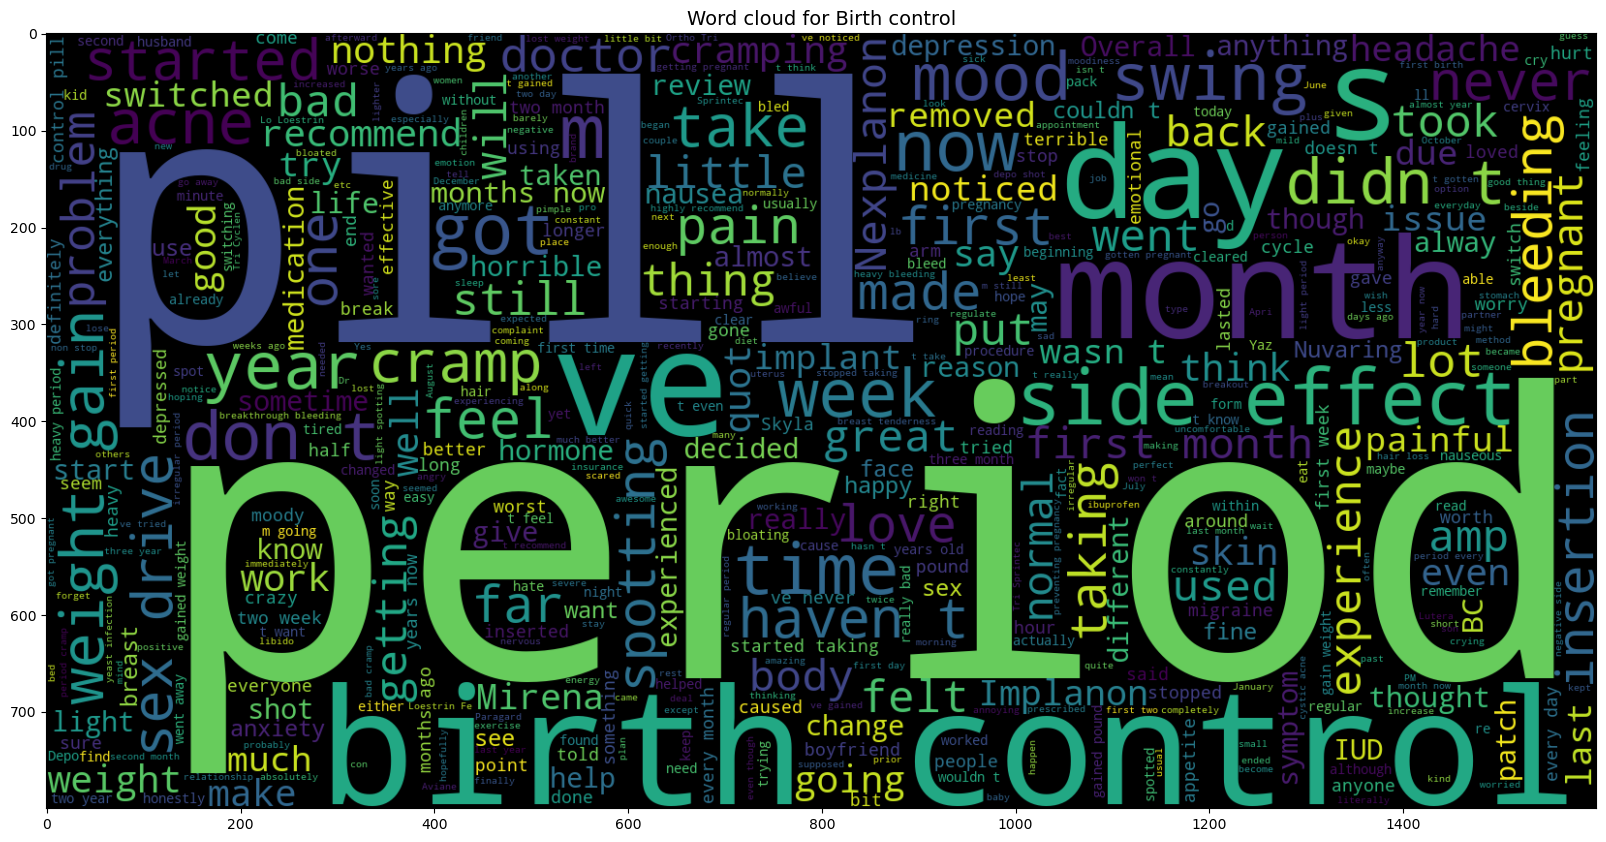

In [27]:
from wordcloud import WordCloud 
plt.figure(figsize = (20,20)) # Text that is fake news headlines
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ".join(X_birth.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Birth control', fontsize=14)

Text(0.5, 1.0, 'Word cloud for Depression')

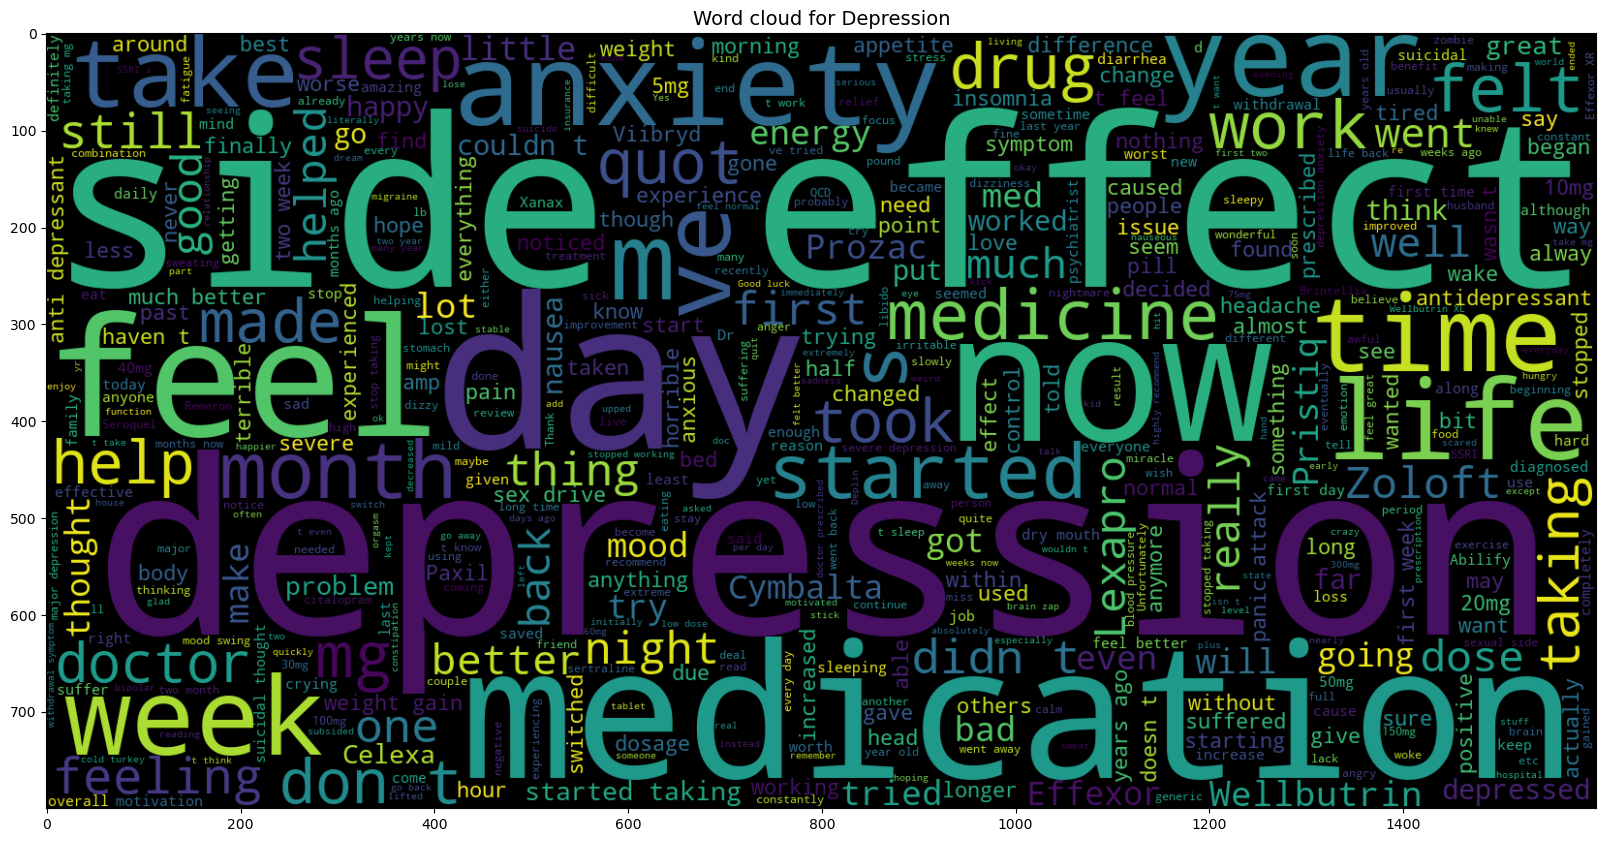

In [134]:
from wordcloud import WordCloud 
plt.figure(figsize = (20,20)) # Text that is fake news headlines
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression', fontsize=14)

Text(0.5, 1.0, 'Word cloud for High Blood Pressure')

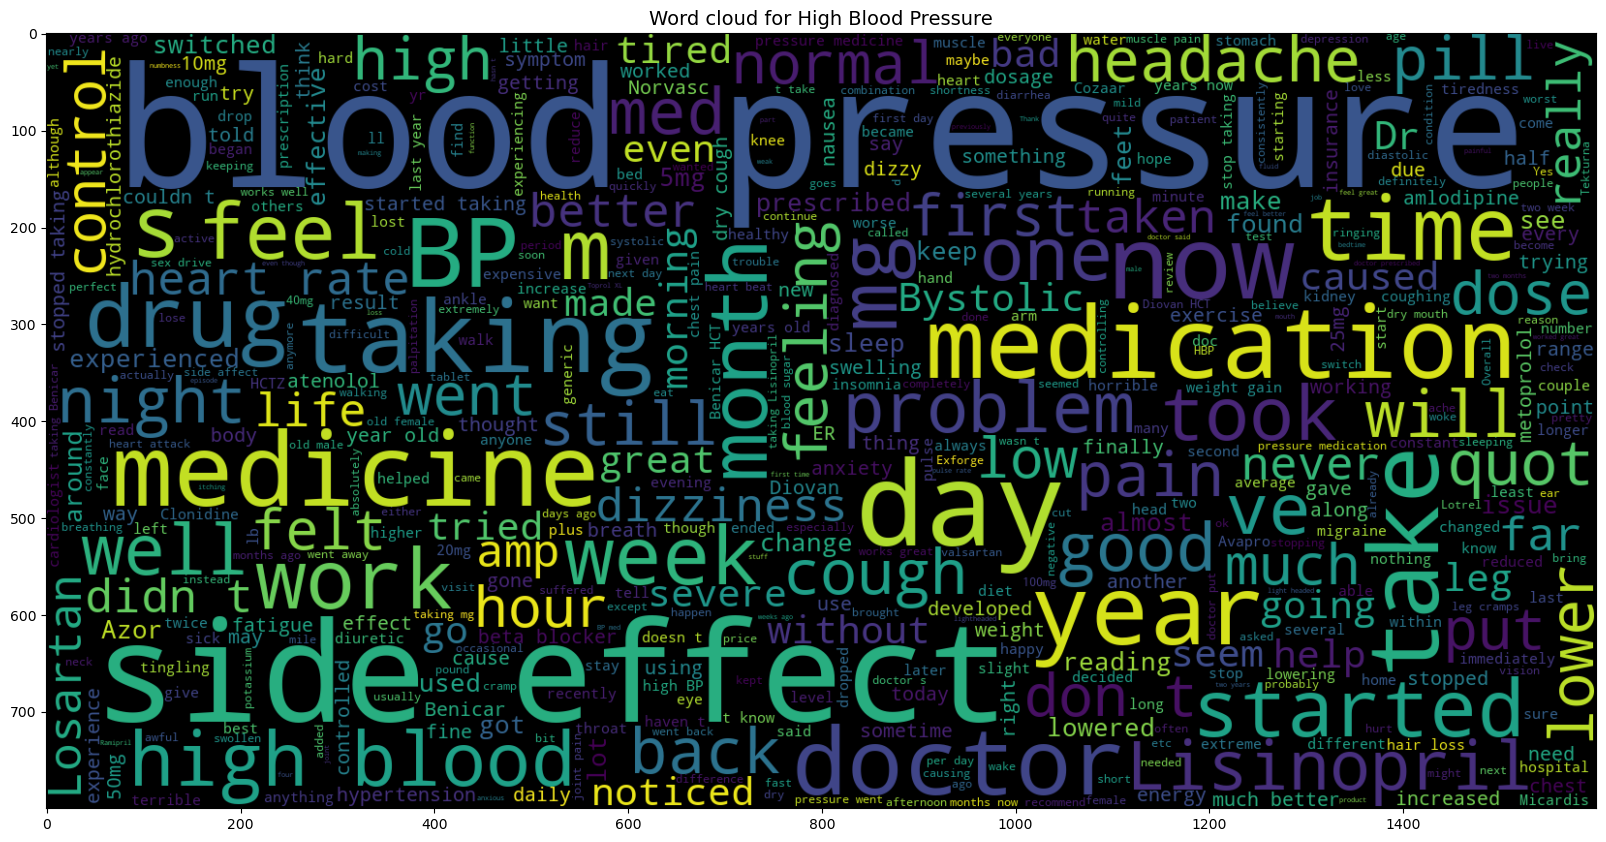

In [136]:
from wordcloud import WordCloud 
plt.figure(figsize = (20,20)) # Text that is fake news headlines
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ".join(X_bp.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for High Blood Pressure', fontsize=14)

Text(0.5, 1.0, 'Word cloud for Diabetes, Type 2')

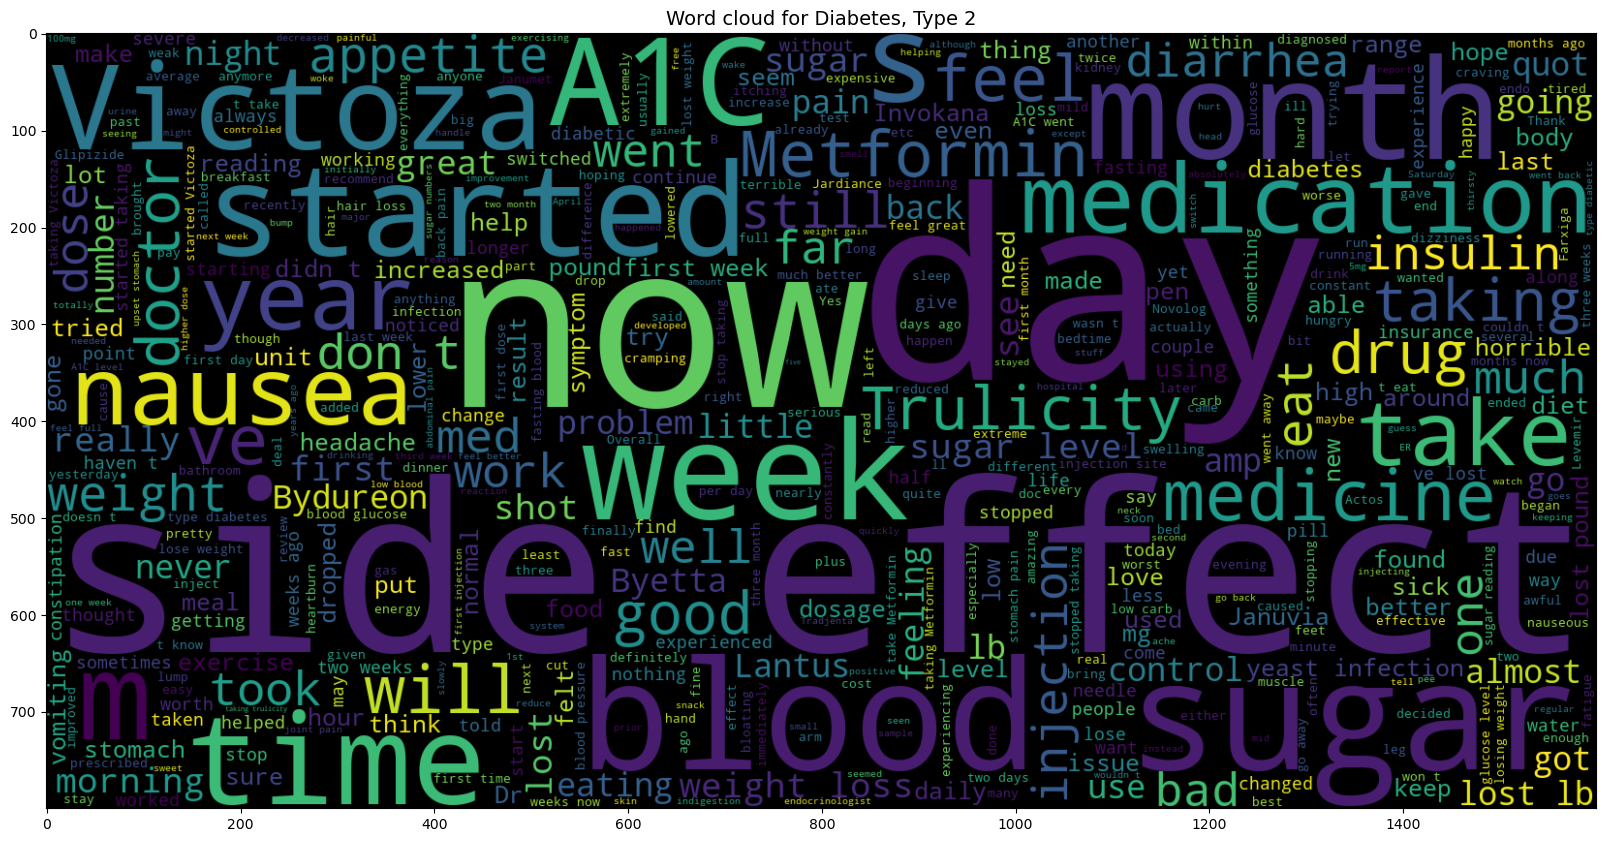

In [138]:
from wordcloud import WordCloud 
plt.figure(figsize = (20,20)) # Text that is fake news headlines
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(" ".join(X_diab.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Diabetes, Type 2', fontsize=14)

## DATA PREPROCESSING

In [36]:
X['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

In [38]:
X['review'][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [40]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [42]:
X.head()

condition                                             review
2   Birth Control  I used to take another oral contraceptive, whi...
3   Birth Control  This is my first time using any form of birth ...
9   Birth Control  I had been on the pill for many years. When my...
11     Depression  I have taken anti-depressants for years, with ...
14  Birth Control  Started Nexplanon 2 months ago because I have ...

## REMOVE STOP WORDS

In [45]:
import nltk
nltk.download('stopwords')  # Download the stopwords corpus

from nltk.corpus import stopwords
stop = stopwords.words('english')  

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [47]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()
stop = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

In [48]:
print(porter.stem("strongly"))


strongli


In [53]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [54]:
print(lemmatizer.lemmatize("strongly"))

strongly


In [56]:
from bs4 import BeautifulSoup
import re

In [57]:
def review_to_words(raw_review):
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    words = letters_only.lower().split()
    meaningful_words = [w for w in words if not w in stop]
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    return(' '.join(lemmitize_words))

In [61]:
X['clean_review'] = X['review'].apply(review_to_words)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6660\2292467243.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


In [62]:
X.head()

condition                                             review  \
2   Birth Control  I used to take another oral contraceptive, whi...   
3   Birth Control  This is my first time using any form of birth ...   
9   Birth Control  I had been on the pill for many years. When my...   
11     Depression  I have taken anti-depressants for years, with ...   
14  Birth Control  Started Nexplanon 2 months ago because I have ...   

                                         clean_review  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

## Creating features and target variables

In [64]:
X_feat = X['clean_review']
y = X['condition']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y, stratify=y,test_size=0.2, random_state=0)

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cmastype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment= "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted labe')

## Bag of Words

In [73]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

## Machine learning Model : Naive Bayes

accuracy: 0.970
Confusion matrix, without normalization


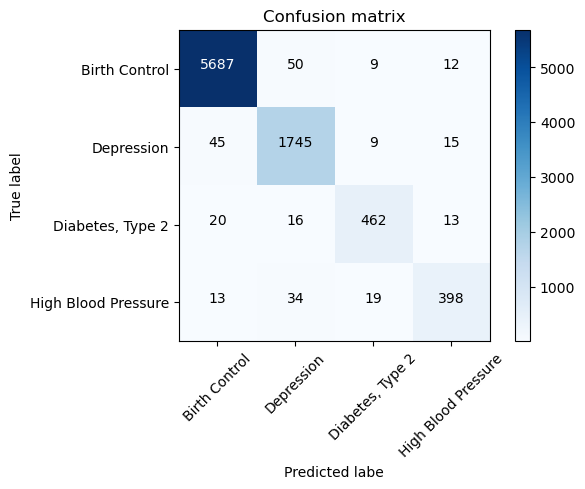

In [76]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])


## Machine learning model : Passive Aggresive classifier

accuracy: 0.977
Confusion matrix, without normalization


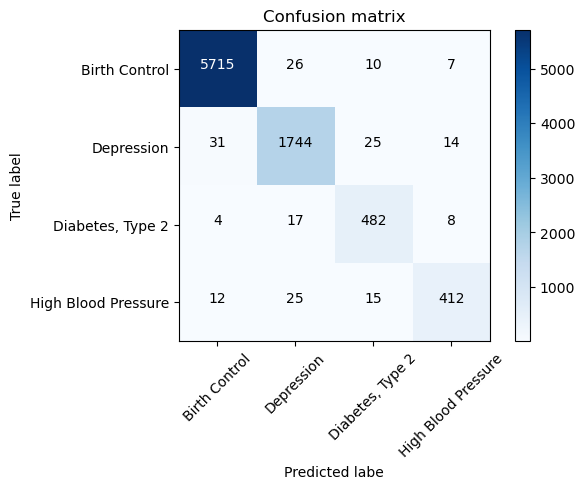

In [79]:
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression

passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

## TFIDF

In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train_2 = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer.transform(X_test)

## Machine Learning Model : Naive Bayes

accuracy: 0.921
Confusion matrix, without normalization


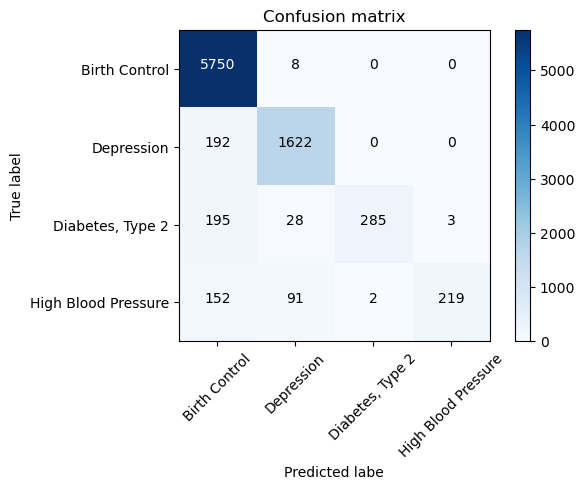

In [84]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train_2, y_train)
pred = mnb_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

## Machine Learning Model TFIDF


accuracy: 0.982
Confusion matrix, without normalization


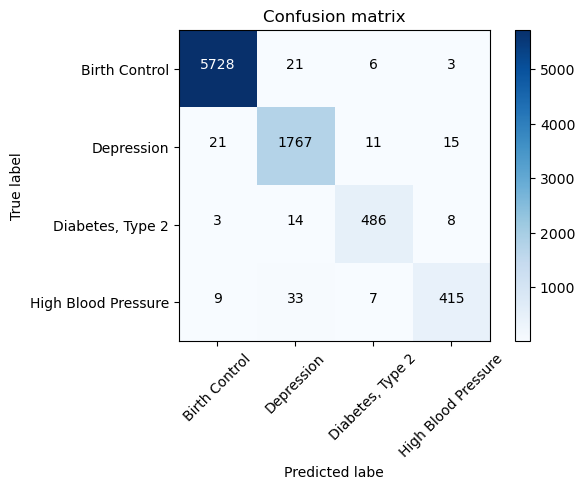

In [112]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf= PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

## TFIDF : BIGRAMS

accuracy: 0.986
Confusion matrix, without normalization


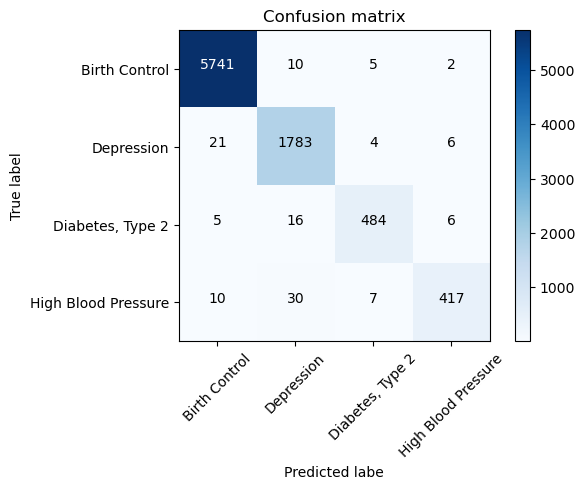

In [91]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

pass_tf= PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

## TFIDF : TRIGRAMS

accuracy: 0.985
Confusion matrix, without normalization


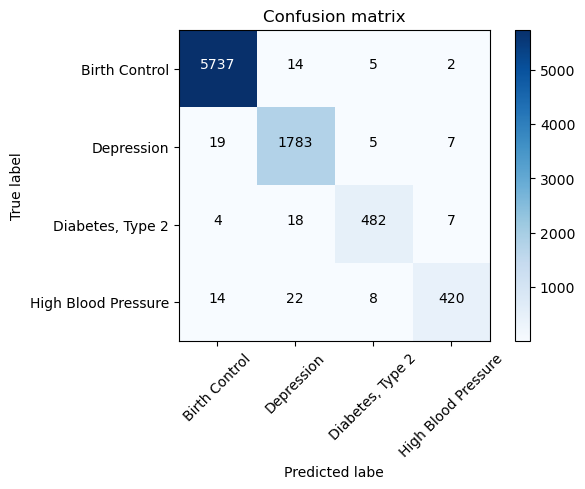

In [93]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.8, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer2.transform(X_test)

pass_tf= PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy: %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression', 'Diabetes, Type 2', 'High Blood Pressure'])

## Most Important Features

In [95]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_name = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_name))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)


most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Birth Control')

Birth Control forumla 0.7413786923838885
Birth Control need 0.7503960400245161
Birth Control estranged 0.7780394177993423
Birth Control excercise 0.7955028770517802
Birth Control twin 1.0286823082798933
Birth Control ask 1.0385189528838121
Birth Control wood 1.3345245283351366
Birth Control valid 1.3937988088567121
Birth Control mega 1.409918285838253
Birth Control case 6.616023347016875


In [96]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression dissociative 1.186906722204932
Depression educated 1.2000368654742621
Depression population 1.2010188451161115
Depression orysthia 1.393465252325416
Depression restored 1.4425595907578252
Depression pimpels 1.5579815444374745
Depression reasoned 1.7066063992930052
Depression rebooting 1.9149767666557511
Depression acknowledges 3.446941767480232
Depression refilling 4.778696751869771


In [97]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'High Blood Pressure')

High Blood Pressure nanny 0.7602833198839345
High Blood Pressure buuuuut 0.7982506138372815
High Blood Pressure buoyant 0.8007332565415759
High Blood Pressure polydipsia 0.9513191472400497
High Blood Pressure newly 0.9670736349969249
High Blood Pressure gi 0.9808067778369731
High Blood Pressure disodium 1.0415168999733846
High Blood Pressure newborn 1.0550920385672329
High Blood Pressure print 2.0152578385830004
High Blood Pressure panick 4.021882269930343


In [103]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Diabetes, Type 2')

Diabetes, Type 2 unintentionally 0.5765853663172459
Diabetes, Type 2 zoryl 0.5903542423827214
Diabetes, Type 2 hobble 0.6071100518259441
Diabetes, Type 2 nyquil 0.719524475872052
Diabetes, Type 2 definite 0.7657023296528143
Diabetes, Type 2 carefully 1.0426050879125157
Diabetes, Type 2 text 1.3444474418593875
Diabetes, Type 2 nuvigal 2.0781259174865947
Diabetes, Type 2 hmo 2.5412925089779237
Diabetes, Type 2 def 3.0596992433205483


## SAMPLE PREDICTION

In [106]:
X.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \...   
161278  I just got diagnosed with type 2. My doctor pr...   
161286  This is the third med I&#039;ve tried for anxi...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             clean_review  
161273  nexplanon since dec got first period end janua...  
161278  got diagnosed type doctor prescribed invokana ...  
161286  third med tried anxiety mild depression week h...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

In [114]:
text = ["This is the third med I&#039;ve tried for anxi...	"]
test = tfidf_vectorizer.transform(text)
pred1 = pass_tf.predict(test)[0]
pred1

'Depression'

In [116]:
text = ["This would be my second month on Junel. I&#039...	"]
test = tfidf_vectorizer.transform(text)
prediction = pass_tf.predict(test)[0]
prediction

'Birth Control'

## Function for extracting Top drugs

In [119]:
def top_drugs_extraction(condition):
    # Filter the DataFrame based on rating and usefulCount
    df_top = df[(df['rating'] >= 9) & (df['usefulCount'] >= 100)].sort_values(by=['rating', 'usefulCount'], ascending=[False, False])
    
    # Extract the top 3 drugs for the specified condition
    drug_lst = df_top[df_top['condition'] == condition]['drugName'].head(5).tolist()
    
    return drug_lst

In [121]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction'] = prediction
    return df_test

In [123]:
sentences = ["getting prblem day to day liffe not able to gain musle and have problem with running jumpping"]


In [132]:
tfidf_Priyanshu = tfidf_vectorizer.transform(sentences)

prediction = pass_tf.predict(tfidf_Priyanshu)

for text, label in zip(sentences, prediction):
    if label == "High Blood Pressure":
        target = "High Blood Pressure"
        top_drugs = top_drugs_extraction(label)
        print("text:", text, "\nCondition:", target)
        print("Top 5 Suggested Drugs :")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print(top_drugs[3])
        print(top_drugs[4])
        print()
    elif label == "Depression":
         target = "Depression"
         top_drugs = top_drugs_extraction(label)
         print("text:", text, "\nCondition:", target)
         print("Top 5 Suggested Drugs :")
         print(top_drugs[0])
         print(top_drugs[1])
         print(top_drugs[2])
         print(top_drugs[3])
         print(top_drugs[4])
         print()
    elif label == "Diabetes, Type 2":
         target = "Diabetes, Type 2"
         top_drugs = top_drugs_extraction(label)
         print("text:", text, "\nCondition:", target)
         print("Top 5 Suggested Drugs :")
         print(top_drugs[0])
         print(top_drugs[1])
         print(top_drugs[2])
         print(top_drugs[3])
         print(top_drugs[4])
         print()
    else:
         target = "Birth control"
         top_drugs = top_drugs_extraction(label)
         print("text:", text, "\nCondition:", target)
         print("Top 5 Suggested Drugs :")
         print(top_drugs[0])
         print(top_drugs[1])
         print(top_drugs[2])
         print(top_drugs[3])
         print(top_drugs[4])
         print()

text: getting prblem day to day liffe not able to gain musle and have problem with running jumpping 
Condition: Birth control
Top 5 Suggested Drugs :
Mirena
Levonorgestrel
Implanon
Levonorgestrel
Mirena

